# 1 Neural Networks

In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network. The provided script, `ex4.m`, will help you step through this exercise.

## 1.1 Visualizing the data

In the first part of `ex4.m`, the code will load the data and display it on a 2-dimensional plot (Figure 1) by calling the function `displayData`. This is the same dataset that you used in the previous exercise. There are
5000 training examples in `ex3data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location.

The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix `X`. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

$$X = \begin{bmatrix}
- (x^{(1)})^T - \\ 
- (x^{(2)})^T - \\ 
- (x^{(3)})^T - \\ 
\vdots \\ 
- (x^{(m)})^T - \\
\end{bmatrix}$$

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. To make things more compatible with Octave/MATLAB indexing, where there is no zero index, we have mapped the digit zero to the value ten. Therefore, a "0" digit is labeled as "10", while the digits "1" to "9" are labeled as "1" to "9" in their natural order.

In [1]:
function [h, display_array] = displayData(X, example_width)
    %DISPLAYDATA Display 2D data in a nice grid
    %   [h, display_array] = DISPLAYDATA(X, example_width) displays 2D data
    %   stored in X in a nice grid. It returns the figure handle h and the 
    %   displayed array if requested.

    % Set example_width automatically if not passed in
    if ~exist('example_width', 'var') || isempty(example_width) 
        example_width = round(sqrt(size(X, 2)));
    end

    % Gray Image
    colormap(gray);

    % Compute rows, cols
    [m n] = size(X);
    example_height = (n / example_width);

    % Compute number of items to display
    display_rows = floor(sqrt(m));
    display_cols = ceil(m / display_rows);

    % Between images padding
    pad = 1;

    % Setup blank display
    display_array = - ones(pad + display_rows * (example_height + pad), ...
                           pad + display_cols * (example_width + pad));

    % Copy each example into a patch on the display array
    curr_ex = 1;
    for j = 1:display_rows
        for i = 1:display_cols
            if curr_ex > m, 
                break; 
            end
            % Copy the patch

            % Get the max value of the patch
            max_val = max(abs(X(curr_ex, :)));
            display_array(pad + (j - 1) * (example_height + pad) + (1:example_height), ...
                          pad + (i - 1) * (example_width + pad) + (1:example_width)) = ...
                            reshape(X(curr_ex, :), example_height, example_width) / max_val;
            curr_ex = curr_ex + 1;
        end
        if curr_ex > m, 
            break; 
        end
    end

    % Display Image
    h = imagesc(display_array, [-1 1]);

    % Do not show axis
    axis image off

    drawnow;

end


Loading and Visualizing Data ...


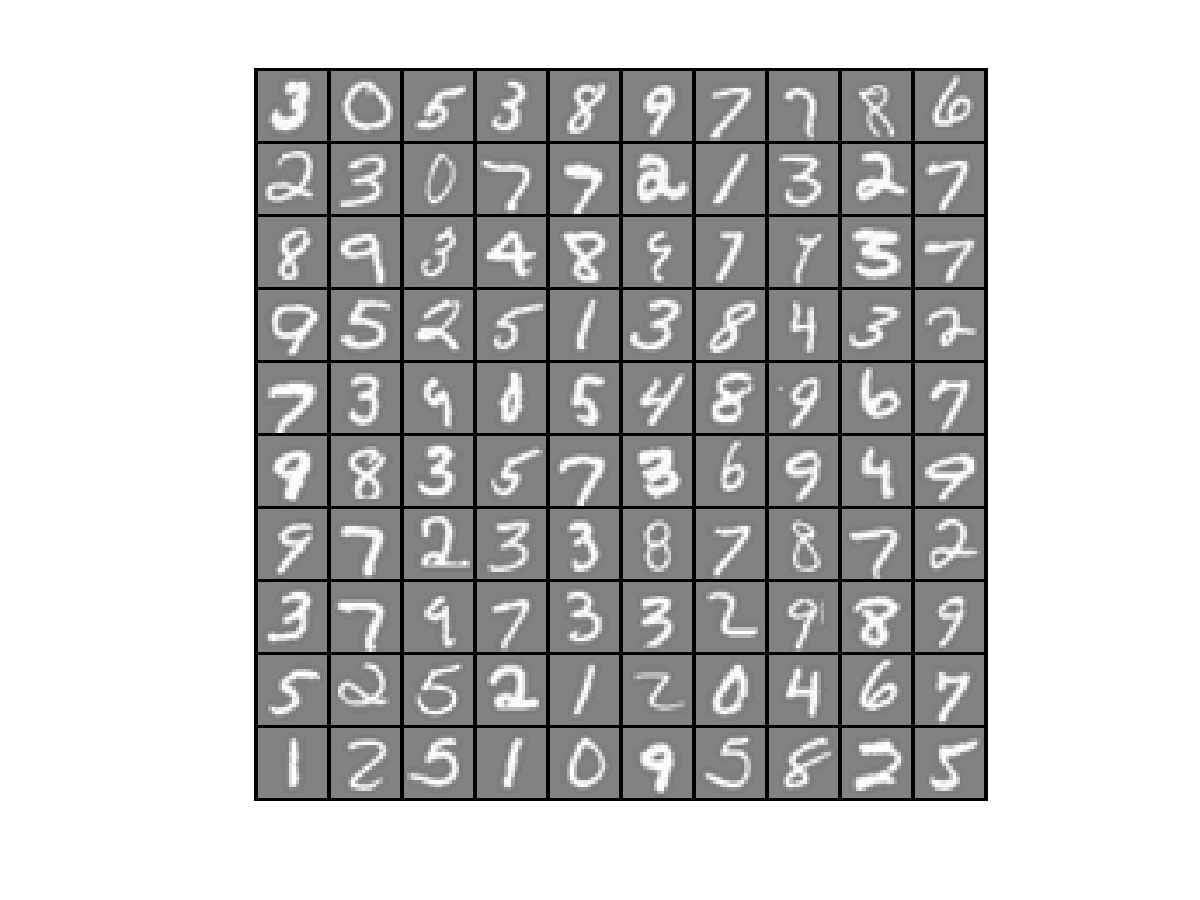

In [2]:
%% Initialization
clear ; close all; clc

%% Setup the parameters you will use for this exercise
input_layer_size  = 400;  % 20x20 Input Images of Digits
hidden_layer_size = 25;   % 25 hidden units
num_labels = 10;          % 10 labels, from 1 to 10   
                          % (note that we have mapped "0" to label 10)

%% =========== Part 1: Loading and Visualizing Data =============
%  We start the exercise by first loading and visualizing the dataset. 
%  You will be working with a dataset that contains handwritten digits.
%

% Load Training Data
fprintf('Loading and Visualizing Data ...\n')

load('/home/roger/Workspace/MOOC/Coursera/MLearning/Week 5/Assignment/ex4/ex4data1.mat');
m = size(X, 1);

% Randomly select 100 data points to display
sel = randperm(size(X, 1));
sel = sel(1:100);

displayData(X(sel, :));

## 1.2 Model representation

Our neural network is shown in Figure 2. It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20 × 20, this gives us 400 input layer units (not counting the extra bias unit which always outputs `+1`). The training data will be loaded into the variables `X` and `y` by the `ex4.m` script. You have been provided with a set of network parameters ($\theta^{(1)}, \theta^{(2)}$) already trained by us. These are stored in `ex4weights.mat` and will be loaded by `ex4.m` into `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

```octave
% Load saved matrices from file
load('ex4weights.mat');
% The matrices Theta1 and Theta2 will now be in your workspace
% Theta1 has size 25 x 401
% Theta2 has size 10 x 26
```
<img src="../Week 4/neuralnet.png", width="50%"/>

In [3]:
%% ================ Part 2: Loading Parameters ================
% In this part of the exercise, we load some pre-initialized 
% neural network parameters.

fprintf('\nLoading Saved Neural Network Parameters ...\n')

% Load the weights into variables Theta1 and Theta2
load('/home/roger/Workspace/MOOC/Coursera/MLearning/Week 5/Assignment/ex4/ex4weights.mat');

% Unroll parameters 
nn_params = [Theta1(:) ; Theta2(:)];


Loading Saved Neural Network Parameters ...


## 1.3 Feedforward and cost function

Now you will implement the cost function and gradient for the neural network. First, complete the code in `nnCostFunction.m` to return the cost. Recall that the cost function for the neural network (without regularization) is

$$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} [-y_k^{(i)}log((h_\Theta(x^{(i)}))_k-(1 - y_k^{(i)})log(1 - h_\Theta(x^{(i)})_k)]$$

where $h_\theta(x^{(i)})$ is computed as shown in the Figure 2 and K = 10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output value) of the k-th output unit. Also, recall that whereas the original labels (in the variable `y`) were 1, 2, ..., 10, for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1, so that

$$y = \begin{bmatrix}
1 \\ 
0 \\ 
0 \\ 
\vdots \\ 
0 \\
\end{bmatrix},  \ \ \ \
\begin{bmatrix}
0 \\ 
1 \\ 
0 \\ 
\vdots \\ 
0 \\
\end{bmatrix},  \ \ \ \
\begin{bmatrix}
0 \\ 
0 \\ 
1 \\ 
\vdots \\ 
0 \\
\end{bmatrix},  \ \ \ \ \dots \text{or} \ \ \ \
\begin{bmatrix}
0 \\ 
0 \\ 
0 \\ 
\vdots \\ 
1 \\
\end{bmatrix}$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0. You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example `i` and sum the cost over all examples. **Your code should also work for a dataset of any size, with any number of labels** (you can assume that there are always at least $K \gt 3$ labels).

**Implementation Note**: The matrix `X` contains the examples in rows (i.e., `X(i,:)'` is the i-th training example $x^{(i)}$, expressed as a n × 1 vector.) When you complete the code in `nnCostFunction.m`, you will need to add the column of 1's to the X matrix. The parameters for each unit in the neural network is represented in `Theta1` and `Theta2` as one row. Specifically, the first row of `Theta1` corresponds to the first hidden unit in the second layer. You can use a for-loop over the examples to compute the cost.

Once you are done, `ex4.m` will call your `nnCostFunction` using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the cost is about 0.287629.

In [4]:
function g = sigmoid(z)
    %SIGMOID Compute sigmoid functoon
    %   J = SIGMOID(z) computes the sigmoid of z.

    g = 1.0 ./ (1.0 + exp(-z));
end

In [15]:
%% Implementing cost function J
%% NOT FINISHED function [Part 1]
function [J grad] = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda)
    %NNCOSTFUNCTION Implements the neural network cost function for a two layer
    %neural network which performs classification
    %   [J grad] = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, ...
    %   X, y, lambda) computes the cost and gradient of the neural network. The
    %   parameters for the neural network are "unrolled" into the vector
    %   nn_params and need to be converted back into the weight matrices. 
    % 
    %   The returned parameter grad should be a "unrolled" vector of the
    %   partial derivatives of the neural network.
    %

    % Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    % for our 2 layer neural network
    Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                     hidden_layer_size, (input_layer_size + 1));

    Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                     num_labels, (hidden_layer_size + 1));

    % Setup some useful variables
    m = size(X, 1);

    % You need to return the following variables correctly 
    J = 0;
    Theta1_grad = zeros(size(Theta1));
    Theta2_grad = zeros(size(Theta2));

    % ====================== YOUR CODE HERE ======================
    % Instructions: You should complete the code by working through the
    %               following parts.
    %
    % Part 1: Feedforward the neural network and return the cost in the
    %         variable J. After implementing Part 1, you can verify that your
    %         cost function computation is correct by verifying the cost
    %         computed in ex4.m
    %
    % Part 2: Implement the backpropagation algorithm to compute the gradients
    %         Theta1_grad and Theta2_grad. You should return the partial derivatives of
    %         the cost function with respect to Theta1 and Theta2 in Theta1_grad and
    %         Theta2_grad, respectively. After implementing Part 2, you can check
    %         that your implementation is correct by running checkNNGradients
    %
    %         Note: The vector y passed into the function is a vector of labels
    %               containing values from 1..K. You need to map this vector into a 
    %               binary vector of 1's and 0's to be used with the neural network
    %               cost function.
    %
    %         Hint: We recommend implementing backpropagation using a for-loop
    %               over the training examples if you are implementing it for the 
    %               first time.
    %
    % Part 3: Implement regularization with the cost function and gradients.
    %
    %         Hint: You can implement this around the code for
    %               backpropagation. That is, you can compute the gradients for
    %               the regularization separately and then add them to Theta1_grad
    %               and Theta2_grad from Part 2.
    %
    y = eye(num_labels)(y,:);
    
    % Part 1
    a1 = [ones(m, 1) X];
    a2 = sigmoid(a1*Theta1');
    a3 = [ones(m, 1) a2];
    a3 = sigmoid(a3*Theta2');
    J = ((1/m) * sum(sum((-y .* log(a3))-((1-y) .* log(1-a3)))));
    % -------------------------------------------------------------

    % =========================================================================

    % Unroll gradients
    grad = [Theta1_grad(:) ; Theta2_grad(:)];
end

In [16]:
%% ================ Part 3: Compute Cost (Feedforward) ================
%  To the neural network, you should first start by implementing the
%  feedforward part of the neural network that returns the cost only. You
%  should complete the code in nnCostFunction.m to return cost. After
%  implementing the feedforward to compute the cost, you can verify that
%  your implementation is correct by verifying that you get the same cost
%  as us for the fixed debugging parameters.
%
%  We suggest implementing the feedforward cost *without* regularization
%  first so that it will be easier for you to debug. Later, in part 4, you
%  will get to implement the regularized cost.
%
fprintf('\nFeedforward Using Neural Network ...\n')

% Weight regularization parameter (we set this to 0 here).
lambda = 0;

J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, ...
                   num_labels, X, y, lambda);

fprintf(['Cost at parameters (loaded from ex4weights): %f '...
         '\n(this value should be about 0.287629)\n'], J);


Feedforward Using Neural Network ...
Cost at parameters (loaded from ex4weights): 0.287629 
(this value should be about 0.287629)


## 1.4 Regularized cost function

The cost function for neural networks with regularization is given by

$$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} [-y_k^{(i)}log((h_\Theta(x^{(i)}))_k-(1 - y_k^{(i)})log(1 - h_\Theta(x^{(i)})_k)] + \frac{\lambda}{2m} \left [\sum_{j=1}^n \sum_{k=1}^K (\Theta_{j, k}^{(1)})^2 + (\Theta_{j, k}^{(2)})^2 \right ]$$

You can assume that the neural network will only have 3 layers – an input layer, a hidden layer and an output layer. However, your code should work for any number of input units, hidden units and outputs units. While we have explicitly listed the indices above for $\theta^{(1)}$ and $\theta^{(2)}$ for clarity, do note that your code should in general work with $\theta^{(1)}$ and $\theta^{(2)}$ of any size.

Note that you should not be regularizing the terms that correspond to the bias. For the matrices `Theta1` and `Theta2`, this corresponds to the first column of each matrix. You should now add regularization to your cost function. Notice that you can first compute the unregularized cost function `J` using your existing `nnCostFunction.m` and then later add the cost for the regularization terms.

Once you are done, `ex4.m` will call your `nnCostFunction` using the loaded set of parameters for `Theta1` and `Theta2`, and $\lambda = 1$. You should see that the cost is about 0.383770.

In [20]:
%% Implementing cost function J
%% NOT FINISHED function [Part 2]
function [J grad] = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda)
    %NNCOSTFUNCTION Implements the neural network cost function for a two layer
    %neural network which performs classification
    %   [J grad] = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, ...
    %   X, y, lambda) computes the cost and gradient of the neural network. The
    %   parameters for the neural network are "unrolled" into the vector
    %   nn_params and need to be converted back into the weight matrices. 
    % 
    %   The returned parameter grad should be a "unrolled" vector of the
    %   partial derivatives of the neural network.
    %

    % Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    % for our 2 layer neural network
    Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                     hidden_layer_size, (input_layer_size + 1));

    Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                     num_labels, (hidden_layer_size + 1));

    % Setup some useful variables
    m = size(X, 1);

    % You need to return the following variables correctly 
    J = 0;
    Theta1_grad = zeros(size(Theta1));
    Theta2_grad = zeros(size(Theta2));

    % ====================== YOUR CODE HERE ======================
    % Instructions: You should complete the code by working through the
    %               following parts.
    %
    % Part 1: Feedforward the neural network and return the cost in the
    %         variable J. After implementing Part 1, you can verify that your
    %         cost function computation is correct by verifying the cost
    %         computed in ex4.m
    %
    % Part 2: Implement the backpropagation algorithm to compute the gradients
    %         Theta1_grad and Theta2_grad. You should return the partial derivatives of
    %         the cost function with respect to Theta1 and Theta2 in Theta1_grad and
    %         Theta2_grad, respectively. After implementing Part 2, you can check
    %         that your implementation is correct by running checkNNGradients
    %
    %         Note: The vector y passed into the function is a vector of labels
    %               containing values from 1..K. You need to map this vector into a 
    %               binary vector of 1's and 0's to be used with the neural network
    %               cost function.
    %
    %         Hint: We recommend implementing backpropagation using a for-loop
    %               over the training examples if you are implementing it for the 
    %               first time.
    %
    % Part 3: Implement regularization with the cost function and gradients.
    %
    %         Hint: You can implement this around the code for
    %               backpropagation. That is, you can compute the gradients for
    %               the regularization separately and then add them to Theta1_grad
    %               and Theta2_grad from Part 2.
    %
    y = eye(num_labels)(y,:);
    
    % Part 1
    a1 = [ones(m, 1) X];
    a2 = sigmoid(a1*Theta1');
    a3 = [ones(m, 1) a2];
    a3 = sigmoid(a3*Theta2');
    J = ((1/m) * sum(sum((-y .* log(a3))-((1-y) .* log(1-a3)))));
    
    % Part 2
    reg1 = (lambda/(2*m)) * sum(sum(Theta1(:, 2:end) .^ 2)); % remove bias from Theta1
    reg2 = (lambda/(2*m)) * sum(sum(Theta2(:, 2:end) .^ 2)); % remove bias from Theta2
    J = J + reg1 + reg2;
    % -------------------------------------------------------------

    % =========================================================================

    % Unroll gradients
    grad = [Theta1_grad(:) ; Theta2_grad(:)];
end

In [21]:
%% =============== Part 4: Implement Regularization ===============
%  Once your cost function implementation is correct, you should now
%  continue to implement the regularization with the cost.
%
fprintf('\nChecking Cost Function (w/ Regularization) ... \n')

% Weight regularization parameter (we set this to 1 here).
lambda = 1;

J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, ...
                   num_labels, X, y, lambda);

fprintf(['Cost at parameters (loaded from ex4weights): %f '...
         '\n(this value should be about 0.383770)\n'], J);


Checking Cost Function (w/ Regularization) ... 
Cost at parameters (loaded from ex4weights): 0.383770 
(this value should be about 0.383770)


# 2 Backpropagation

In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function. You will need to complete the `nnCostFunction.m` so that it returns an appropriate value for grad. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function $J(\theta)$ using an advanced optimizer such as `fmincg`.

You will first implement the backpropagation algorithm to compute the gradients for the parameters for the (unregularized) neural network. After you have verified that your gradient computation for the unregularized case
is correct, you will implement the gradient for the regularized neural network.

## 2.1 Sigmoid gradient

To help you get started with this part of the exercise, you will first implement the sigmoid gradient function. The gradient for the sigmoid function can be computed as

$$g'(z) = \frac{d}{dz}g(z) = g(z)(1 - g(z))$$

where

$$sigmoid(z) = g(z) = \frac{1}{1+e^{-z}}$$

When you are done, try testing a few values by calling `sigmoidGradient(z)` at the Octave/MATLAB command line. For large values (both positive and negative) of `z`, the gradient should be close to 0. When z = 0, the gradient should be exactly 0.25. Your code should also work with vectors and matrices. For a matrix, your function should perform the sigmoid gradient function on every element.

In [5]:
function g = sigmoidGradient(z)
    %SIGMOIDGRADIENT returns the gradient of the sigmoid function
    %evaluated at z
    %   g = SIGMOIDGRADIENT(z) computes the gradient of the sigmoid function
    %   evaluated at z. This should work regardless if z is a matrix or a
    %   vector. In particular, if z is a vector or matrix, you should return
    %   the gradient for each element.

    g = zeros(size(z));

    % ====================== YOUR CODE HERE ======================
    % Instructions: Compute the gradient of the sigmoid function evaluated at
    %               each value of z (z can be a matrix, vector or scalar).
    gz = 1.0 ./ (1.0 + exp(-z));
    g = gz.*(1 - gz);
    % =============================================================
end

In [27]:
%% ================ Part 5: Sigmoid Gradient  ================
%  Before you start implementing the neural network, you will first
%  implement the gradient for the sigmoid function. You should complete the
%  code in the sigmoidGradient.m file.
%
fprintf('\nEvaluating sigmoid gradient...\n')

g = sigmoidGradient([1 -0.5 0 0.5 1]);
fprintf('Sigmoid gradient evaluated at [1 -0.5 0 0.5 1]:\n  ');
fprintf('%f ', g);
fprintf('\n\n');


Evaluating sigmoid gradient...
Sigmoid gradient evaluated at [1 -0.5 0 0.5 1]:
  
0.196612 0.235004 0.250000 0.235004 0.196612 




## 2.2 Random initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range [$-\epsilon_{init}$ , $\epsilon_{init}$]. You should use init = 0.12 (One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in}+L_{out}}}$, where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{(l)}$.) This range of values ensures that the parameters are kept small and makes the learning more efficient. Your job is to complete `randInitializeWeights.m` to initialize the weights for $\Theta$; modify the file and fill in the following code:

```octave
% Randomly initialize the weights to small values
epsilon_init = 0.12;
W = rand(L_out, 1 + L_in) * 2 * epsilon_init − epsilon_init;
```



In [6]:
function W = randInitializeWeights(L_in, L_out)
    %RANDINITIALIZEWEIGHTS Randomly initialize the weights of a layer with L_in
    %incoming connections and L_out outgoing connections
    %   W = RANDINITIALIZEWEIGHTS(L_in, L_out) randomly initializes the weights 
    %   of a layer with L_in incoming connections and L_out outgoing 
    %   connections. 
    %
    %   Note that W should be set to a matrix of size(L_out, 1 + L_in) as
    %   the column row of W handles the "bias" terms
    %

    % You need to return the following variables correctly 
    W = zeros(L_out, 1 + L_in);

    % ====================== YOUR CODE HERE ======================
    % Instructions: Initialize W randomly so that we break the symmetry while
    %               training the neural network.
    %
    % Note: The first row of W corresponds to the parameters for the bias units
    %
    % Randomly initialize the weights to small values

    epsilon_init = 0.12;
    W = rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init;

    % =========================================================================
end

In [15]:
%% ================ Part 6: Initializing Pameters ================
%  In this part of the exercise, you will be starting to implment a two
%  layer neural network that classifies digits. You will start by
%  implementing a function to initialize the weights of the neural network
%  (randInitializeWeights.m)

fprintf('\nInitializing Neural Network Parameters ...\n')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size);
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels);

% Unroll parameters
initial_nn_params = [initial_Theta1(:) ; initial_Theta2(:)];


Initializing Neural Network Parameters ...


## 2.3 Backpropagation

<img src="backprop.png", width="50%"/>

Now, you will implement the backpropagation algorithm. Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example ($x^{(t)}, y^{(t)}$), we will first run a "forward pass" to compute all the activations throughout the network, including the output value of the hypothesis $h_\theta(x)$. Then, for each node `j` in layer `l`, we would like to compute an "error term" $\delta_j^{(l)}$ that measures how much that node was "responsible" for any errors in our output.

For an output node, we can directly measure the difference between the network's activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l+1)$.

In detail, here is the backpropagation algorithm (also depicted in Figure 3). You should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, you should implement a for-loop `for t = 1:m` and place steps 1-4 below inside the for-loop, with the t-th iteration performing the calculation on the t-th training example ($x^{(t)}, y^{(t)}$). Step 5 will divide the accumulated gradients by $m$ to obtain the gradients for the neural network cost function.

1) Set the input layer’s values ($a^{(1)}$) to the t-th training example $x^{(t)}$. Perform a feedforward pass (Figure 2), computing the activations ($z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)}$) for layers 2 and 3. Note that you need to add a $+1$ term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit. In Octave/MATLAB, if a 1 is a column vector, adding one corresponds to `a_1 = [1; a_1]`. 

2) For each output unit $k$ in layer 3 (the output layer), set

$$\delta_k^{(3)} = (a_k^{(3)} - y_k)$$

where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k (y_k = 1)$, or if it belongs to a different class $(y_k = 0)$. You may find logical arrays helpful for this task (explained in the previous programming exercise).

3) For the hidden layer $l=2$, set

$$\delta^{(2)} = (\Theta^{(2)})^T\delta^{(3)} .* g'(z^{(2)})$$

4) Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$ . In Octave/MATLAB, removing $\delta_0^{(2)}$ corresponds to `delta_2 = delta_2(2:end)`.

$$\Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)}(a^{(1)})^T$$

5) Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:

$$\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)}$$

**Octave/MATLAB Tip**: You should implement the backpropagation algorithm only after you have successfully completed the feedforward and cost functions. While implementing the backpropagation algorithm, it is often useful to use the size function to print out the sizes of the variables you are working with if you run into dimension mismatch errors ("nonconformant arguments" errors in Octave/MATLAB).

After you have implemented the backpropagation algorithm, the script `ex4.m` will proceed to run gradient checking on your implementation. The gradient check will allow you to increase your confidence that your code is computing the gradients correctly.

In [54]:
% Implementing backpropagation
function [J grad] = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda)
    %NNCOSTFUNCTION Implements the neural network cost function for a two layer
    %neural network which performs classification
    %   [J grad] = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, ...
    %   X, y, lambda) computes the cost and gradient of the neural network. The
    %   parameters for the neural network are "unrolled" into the vector
    %   nn_params and need to be converted back into the weight matrices. 
    % 
    %   The returned parameter grad should be a "unrolled" vector of the
    %   partial derivatives of the neural network.
    %

    % Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    % for our 2 layer neural network
    Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                     hidden_layer_size, (input_layer_size + 1));

    Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                     num_labels, (hidden_layer_size + 1));

    % Setup some useful variables
    m = size(X, 1);

    % You need to return the following variables correctly 
    J = 0;
    Theta1_grad = zeros(size(Theta1));
    Theta2_grad = zeros(size(Theta2));

    % ====================== YOUR CODE HERE ======================
    % Instructions: You should complete the code by working through the
    %               following parts.
    %
    % Part 1: Feedforward the neural network and return the cost in the
    %         variable J. After implementing Part 1, you can verify that your
    %         cost function computation is correct by verifying the cost
    %         computed in ex4.m
    %
    % Part 2: Implement the backpropagation algorithm to compute the gradients
    %         Theta1_grad and Theta2_grad. You should return the partial derivatives of
    %         the cost function with respect to Theta1 and Theta2 in Theta1_grad and
    %         Theta2_grad, respectively. After implementing Part 2, you can check
    %         that your implementation is correct by running checkNNGradients
    %
    %         Note: The vector y passed into the function is a vector of labels
    %               containing values from 1..K. You need to map this vector into a 
    %               binary vector of 1's and 0's to be used with the neural network
    %               cost function.
    %
    %         Hint: We recommend implementing backpropagation using a for-loop
    %               over the training examples if you are implementing it for the 
    %               first time.
    %
    % Part 3: Implement regularization with the cost function and gradients.
    %
    %         Hint: You can implement this around the code for
    %               backpropagation. That is, you can compute the gradients for
    %               the regularization separately and then add them to Theta1_grad
    %               and Theta2_grad from Part 2.
    %
    Y = eye(num_labels)(y,:);

    % feedforward
    a1 = [ones(m, 1) X];
    z2 = a1*Theta1';
    a2 = [ones(size(z2, 1), 1) sigmoid(z2)];
    z3 = a2*Theta2';
    a3 = sigmoid(z3);
    h = a3;
    J = (1/m) * sum(sum((-Y).*log(h) - (1-Y).*log(1-h), 2));

    % regularization
    reg1 = sum(sum(Theta1(:, 2:end).^2, 2));
    reg2 = sum(sum(Theta2(:, 2:end).^2, 2));

    % calculate J
    J = J + (lambda/(2*m)) * (reg1+reg2);

    % backprop
    delta3 = h - Y;
    a2_grad = sigmoidGradient([ones(size(z2, 1), 1) z2]);
    delta2 = (delta3*Theta2) .* a2_grad;
    delta2 = delta2(:, 2:end);

    % accumulate gradients
    Delta1 = (delta2'*a1);
    Delta2 = (delta3'*a2);  
    % -------------------------------------------------------------

    % =========================================================================

    % Unroll gradients
    grad = [Theta1_grad(:) ; Theta2_grad(:)];
end

## 2.4 Gradient checking

In your neural network, you are minimizing the cost function $J(\Theta)$. To perform gradient checking on your parameters, you can imagine "unrolling" the parameters $\Theta^{(1)}$, $\Theta^{(2)}$ into a long vector $\Theta$. By doing so, you can think of the cost function being $J(\theta)$ instead and use the following gradient checking procedure.

Suppose you have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial\theta_i}J(\theta)$; you'd like to check if $f_i$ is outputting correct derivative values.

$$\text{Let} \theta^{(i+)} = \theta + \begin{bmatrix}
0 \\ 
0 \\ 
\vdots \\
\epsilon \\
\vdots \\
0 \\
\end{bmatrix}, \ \ \ \ \text{and} \ \ \ \ 
\theta^{(i-)} = \theta - \begin{bmatrix}
0 \\ 
0 \\ 
\vdots \\
\epsilon \\
\vdots \\
0 \\
\end{bmatrix}$$

So, $\theta^{(i+)}$ is the same as $\theta$, except its i-th element has been incremented by $\epsilon$. Similarly, $\theta^{(i−)}$ is the corresponding vector with the i-th element decreased by $\epsilon$. You can now numerically verify $f_i(\theta)$'s correctness by checking, for each $i$, that:

$$f_i(\theta) \approx \frac{J(\theta^{(i+)}) - J(\theta^{(i-)})}{2\epsilon}$$

The degree to which these two values should approximate each other will depend on the details of $J$. But assuming $\epsilon = 10^{-4}$ , you'll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more).

We have implemented the function to compute the numerical gradient for you in `computeNumericalGradient.m`. While you are not required to modify the file, we highly encourage you to take a look at the code to understand how it works.

In the next step of `ex4.m`, it will run the provided function `checkNNGradients.m` which will create a small neural network and dataset that will be used for checking your gradients. If your backpropagation implementation is correct, you should see a relative difference that is less than 1e-9.

**Practical Tip**: When performing gradient checking, it is much more efficient to use a small neural network with a relatively small number of input units and hidden units, thus having a relatively small number of parameters. Each dimension of $\theta$ requires two evaluations of the cost function and this can be expensive. In the function `checkNNGradients`, our code creates a small random model and dataset which is used with `computeNumericalGradient` for gradient checking. Furthermore, after you are confident that your gradient computations are correct, you should turn off gradient checking before running your learning algorithm.

**Practical Tip**: Gradient checking works for any function where you are computing the cost and the gradient. Concretely, you can use the same `computeNumericalGradient.m` function to check if your gradient implementations for the other exercises are correct too (e.g., logistic regression's cost function).

In [9]:
%% =============== Part 7: Implement Backpropagation ===============
%  Once your cost matches up with ours, you should proceed to implement the
%  backpropagation algorithm for the neural network. You should add to the
%  code you've written in nnCostFunction.m to return the partial
%  derivatives of the parameters.
%

function numgrad = computeNumericalGradient(J, theta)
    %COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
    %and gives us a numerical estimate of the gradient.
    %   numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
    %   gradient of the function J around theta. Calling y = J(theta) should
    %   return the function value at theta.

    % Notes: The following code implements numerical gradient checking, and 
    %        returns the numerical gradient.It sets numgrad(i) to (a numerical 
    %        approximation of) the partial derivative of J with respect to the 
    %        i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
    %        be the (approximately) the partial derivative of J with respect 
    %        to theta(i).)
    %                

    numgrad = zeros(size(theta));
    perturb = zeros(size(theta));
    e = 1e-4;
    for p = 1:numel(theta)
        % Set perturbation vector
        perturb(p) = e;
        loss1 = J(theta - perturb);
        loss2 = J(theta + perturb);
        % Compute Numerical Gradient
        numgrad(p) = (loss2 - loss1) / (2*e);
        perturb(p) = 0;
    end

end

function W = debugInitializeWeights(fan_out, fan_in)
    %DEBUGINITIALIZEWEIGHTS Initialize the weights of a layer with fan_in
    %incoming connections and fan_out outgoing connections using a fixed
    %strategy, this will help you later in debugging
    %   W = DEBUGINITIALIZEWEIGHTS(fan_in, fan_out) initializes the weights 
    %   of a layer with fan_in incoming connections and fan_out outgoing 
    %   connections using a fix set of values
    %
    %   Note that W should be set to a matrix of size(1 + fan_in, fan_out) as
    %   the first row of W handles the "bias" terms
    %

    % Set W to zeros
    W = zeros(fan_out, 1 + fan_in);

    % Initialize W using "sin", this ensures that W is always of the same
    % values and will be useful for debugging
    W = reshape(sin(1:numel(W)), size(W)) / 10;

    % =========================================================================
end

function checkNNGradients(lambda)
    %CHECKNNGRADIENTS Creates a small neural network to check the
    %backpropagation gradients
    %   CHECKNNGRADIENTS(lambda) Creates a small neural network to check the
    %   backpropagation gradients, it will output the analytical gradients
    %   produced by your backprop code and the numerical gradients (computed
    %   using computeNumericalGradient). These two gradient computations should
    %   result in very similar values.
    %

    if ~exist('lambda', 'var') || isempty(lambda)
        lambda = 0;
    end

    input_layer_size = 3;
    hidden_layer_size = 5;
    num_labels = 3;
    m = 5;

    % We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size);
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size);
    % Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(m, input_layer_size - 1);
    y  = 1 + mod(1:m, num_labels)';

    % Unroll parameters
    nn_params = [Theta1(:) ; Theta2(:)];

    % Short hand for cost function
    costFunc = @(p) nnCostFunction(p, input_layer_size, hidden_layer_size, ...
                                   num_labels, X, y, lambda);

    [cost, grad] = costFunc(nn_params);
    numgrad = computeNumericalGradient(costFunc, nn_params);

    % Visually examine the two gradient computations.  The two columns
    % you get should be very similar. 
    disp([numgrad grad]);
    fprintf(['The above two columns you get should be very similar.\n' ...
             '(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n']);

    % Evaluate the norm of the difference between two solutions.  
    % If you have a correct implementation, and assuming you used EPSILON = 0.0001 
    % in computeNumericalGradient.m, then diff below should be less than 1e-9
    diff = norm(numgrad-grad)/norm(numgrad+grad);

    fprintf(['If your backpropagation implementation is correct, then \n' ...
             'the relative difference will be small (less than 1e-9). \n' ...
             '\nRelative Difference: %g\n'], diff);
end


fprintf('\nChecking Backpropagation... \n');

%  Check gradients by running checkNNGradients
checkNNGradients;


Checking Backpropagation... 
  -9.2783e-03  -9.2783e-03
   8.8991e-03   8.8991e-03
  -8.3601e-03  -8.3601e-03
   7.6281e-03   7.6281e-03
  -6.7480e-03  -6.7480e-03
  -3.0498e-06  -3.0498e-06
   1.4287e-05   1.4287e-05
  -2.5938e-05  -2.5938e-05
   3.6988e-05   3.6988e-05
  -4.6876e-05  -4.6876e-05
  -1.7506e-04  -1.7506e-04
   2.3315e-04   2.3315e-04
  -2.8747e-04  -2.8747e-04
   3.3532e-04   3.3532e-04
  -3.7622e-04  -3.7622e-04
  -9.6266e-05  -9.6266e-05
   1.1798e-04   1.1798e-04
  -1.3715e-04  -1.3715e-04
   1.5325e-04   1.5325e-04
  -1.6656e-04  -1.6656e-04
   3.1454e-01   3.1454e-01
   1.1106e-01   1.1106e-01
   9.7401e-02   9.7401e-02
   1.6409e-01   1.6409e-01
   5.7574e-02   5.7574e-02
   5.0458e-02   5.0458e-02
   1.6457e-01   1.6457e-01
   5.7787e-02   5.7787e-02
   5.0753e-02   5.0753e-02
   1.5834e-01   1.5834e-01
   5.5924e-02   5.5924e-02
   4.9162e-02   4.9162e-02
   1.5113e-01   1.5113e-01
   5.3697e-02   5.3697e-02
   4.7146e-02   4.7146e-02
   1.4957e-01   1.4957e-0

## 2.5 Regularized Neural Networks

After you have successfully implemeted the backpropagation algorithm, you will add regularization to the gradient. To account for regularization, it turns out that you can add this as an additional term after computing the gradients using backpropagation.

Specifically, after you have computed $\Delta_{ij}^{(l)}$ using backpropagation, you should add regularization using

$$\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)}  \ \ \ \ \ \ \ \ \ \ \ \  \ \ \ \ \ \ \ \text{for} \ \ j=0 $$

$$\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)} + \frac{\lambda}{m}\Theta_{ij}^{(l)}  \ \ \ \ \text{for} \ \ j\geq1 $$

Note that you should not be regularizing the first column of $\Theta^{(l)}$ which is used for the bias term. Furthermore, in the parameters $\Theta_{ij}^{(l)}$, $i$ is indexed starting from 1, and $j$ is indexed starting from $\Theta$. Thus,

$$\Theta^{(l)} = \begin{bmatrix}
\Theta_{1,0}^{(i)} & \Theta_{1,1}^{(l)} & \dots \\ 
\Theta_{2,0}^{(i)} & \Theta_{2,1}^{(l)} & \\ 
\vdots             &                    & \ddots\\
\end{bmatrix}$$

Somewhat confusingly, indexing in Octave/MATLAB starts from 1 (for both $i$ and $j$), thus $Theta1(2, 1)$ actually corresponds to $\Theta_{2,0}$ (i.e., the entry in the second row, first column of the matrix $\Theta(1)$ shown above)

Now modify your code that computes grad in `nnCostFunction` to account for regularization. After you are done, the `ex4.m` script will proceed to run gradient checking on your implementation. If your code is correct, you should expect to see a relative difference that is less than 1e-9.

In [10]:
function [J grad] = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda)
    %NNCOSTFUNCTION Implements the neural network cost function for a two layer
    %neural network which performs classification
    %   [J grad] = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, ...
    %   X, y, lambda) computes the cost and gradient of the neural network. The
    %   parameters for the neural network are "unrolled" into the vector
    %   nn_params and need to be converted back into the weight matrices. 
    % 
    %   The returned parameter grad should be a "unrolled" vector of the
    %   partial derivatives of the neural network.
    %

    % Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    % for our 2 layer neural network
    Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                     hidden_layer_size, (input_layer_size + 1));

    Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                     num_labels, (hidden_layer_size + 1));

    % Setup some useful variables
    m = size(X, 1);

    % You need to return the following variables correctly 
    J = 0;
    Theta1_grad = zeros(size(Theta1));
    Theta2_grad = zeros(size(Theta2));

    % ====================== YOUR CODE HERE ======================
    % Instructions: You should complete the code by working through the
    %               following parts.
    %
    % Part 1: Feedforward the neural network and return the cost in the
    %         variable J. After implementing Part 1, you can verify that your
    %         cost function computation is correct by verifying the cost
    %         computed in ex4.m
    %
    % Part 2: Implement the backpropagation algorithm to compute the gradients
    %         Theta1_grad and Theta2_grad. You should return the partial derivatives of
    %         the cost function with respect to Theta1 and Theta2 in Theta1_grad and
    %         Theta2_grad, respectively. After implementing Part 2, you can check
    %         that your implementation is correct by running checkNNGradients
    %
    %         Note: The vector y passed into the function is a vector of labels
    %               containing values from 1..K. You need to map this vector into a 
    %               binary vector of 1's and 0's to be used with the neural network
    %               cost function.
    %
    %         Hint: We recommend implementing backpropagation using a for-loop
    %               over the training examples if you are implementing it for the 
    %               first time.
    %
    % Part 3: Implement regularization with the cost function and gradients.
    %
    %         Hint: You can implement this around the code for
    %               backpropagation. That is, you can compute the gradients for
    %               the regularization separately and then add them to Theta1_grad
    %               and Theta2_grad from Part 2.
    %
    Y = eye(num_labels)(y,:);

    % feedforward
    a1 = [ones(m, 1) X];
    z2 = a1*Theta1';
    a2 = [ones(size(z2, 1), 1) sigmoid(z2)];
    z3 = a2*Theta2';
    a3 = sigmoid(z3);
    h = a3;
    J = (1/m) * sum(sum((-Y).*log(h) - (1-Y).*log(1-h), 2));

    % regularization
    reg1 = sum(sum(Theta1(:, 2:end).^2, 2));
    reg2 = sum(sum(Theta2(:, 2:end).^2, 2));

    % calculate J
    J = J + (lambda/(2*m)) * (reg1+reg2);

    % backprop
    delta3 = h - Y;
    a2_grad = sigmoidGradient([ones(size(z2, 1), 1) z2]);
    delta2 = (delta3*Theta2) .* a2_grad;
    delta2 = delta2(:, 2:end);

    % accumulate gradients
    Delta1 = (delta2'*a1);
    Delta2 = (delta3'*a2);

    % calculate regularized gradient
    reg_grad1 = (lambda/m)*[zeros(size(Theta1, 1), 1) Theta1(:, 2:end)];
    reg_grad2 = (lambda/m)*[zeros(size(Theta2, 1), 1) Theta2(:, 2:end)];
    Theta1_grad = Delta1./m + reg_grad1;
    Theta2_grad = Delta2./m + reg_grad2;
  
    % -------------------------------------------------------------

    % =========================================================================

    % Unroll gradients
    grad = [Theta1_grad(:) ; Theta2_grad(:)];
end

In [12]:
%% =============== Part 8: Implement Regularization ===============
%  Once your backpropagation implementation is correct, you should now
%  continue to implement the regularization with the cost and gradient.
%

fprintf('\nChecking Backpropagation (w/ Regularization) ... \n')

%  Check gradients by running checkNNGradients
lambda = 3;
%checkNNGradients(lambda);

% Also output the costFunction debugging values
debug_J  = nnCostFunction(nn_params, input_layer_size, ...
                          hidden_layer_size, num_labels, X, y, lambda);

fprintf(['\n\nCost at (fixed) debugging parameters (w/ lambda = 10): %f ' ...
         '\n(this value should be about 0.576051)\n\n'], debug_J);




Checking Backpropagation (w/ Regularization) ... 


Cost at (fixed) debugging parameters (w/ lambda = 10): 0.576051 
(this value should be about 0.576051)



## 2.6 Learning parameters using `fmincg`

After you have successfully implemented the neural network cost function and gradient computation, the next step of the `ex4.m` script will use `fmincg` to learn a good set parameters.

After the training completes, the `ex4.m` script will proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct. If your implementation is correct, you should see a reported training accuracy of about 95.3% (this may vary by about 1% due to the random initialization). It is possible to get higher training accuracies by training the neural network for more iterations. We encourage you to try training the neural network for more iterations (e.g., set `MaxIter` to 400) and also vary the regularization parameter $\lambda$. With the right learning settings, it is possible to get the neural network to perfectly fit the training set.

In [13]:
function [X, fX, i] = fmincg(f, X, options, P1, P2, P3, P4, P5)
    % Minimize a continuous differentialble multivariate function. Starting point
    % is given by "X" (D by 1), and the function named in the string "f", must
    % return a function value and a vector of partial derivatives. The Polack-
    % Ribiere flavour of conjugate gradients is used to compute search directions,
    % and a line search using quadratic and cubic polynomial approximations and the
    % Wolfe-Powell stopping criteria is used together with the slope ratio method
    % for guessing initial step sizes. Additionally a bunch of checks are made to
    % make sure that exploration is taking place and that extrapolation will not
    % be unboundedly large. The "length" gives the length of the run: if it is
    % positive, it gives the maximum number of line searches, if negative its
    % absolute gives the maximum allowed number of function evaluations. You can
    % (optionally) give "length" a second component, which will indicate the
    % reduction in function value to be expected in the first line-search (defaults
    % to 1.0). The function returns when either its length is up, or if no further
    % progress can be made (ie, we are at a minimum, or so close that due to
    % numerical problems, we cannot get any closer). If the function terminates
    % within a few iterations, it could be an indication that the function value
    % and derivatives are not consistent (ie, there may be a bug in the
    % implementation of your "f" function). The function returns the found
    % solution "X", a vector of function values "fX" indicating the progress made
    % and "i" the number of iterations (line searches or function evaluations,
    % depending on the sign of "length") used.
    %
    % Usage: [X, fX, i] = fmincg(f, X, options, P1, P2, P3, P4, P5)
    %
    % See also: checkgrad 
    %
    % Copyright (C) 2001 and 2002 by Carl Edward Rasmussen. Date 2002-02-13
    %
    %
    % (C) Copyright 1999, 2000 & 2001, Carl Edward Rasmussen
    % 
    % Permission is granted for anyone to copy, use, or modify these
    % programs and accompanying documents for purposes of research or
    % education, provided this copyright notice is retained, and note is
    % made of any changes that have been made.
    % 
    % These programs and documents are distributed without any warranty,
    % express or implied.  As the programs were written for research
    % purposes only, they have not been tested to the degree that would be
    % advisable in any important application.  All use of these programs is
    % entirely at the user's own risk.
    %
    % [ml-class] Changes Made:
    % 1) Function name and argument specifications
    % 2) Output display
    %

    % Read options
    if exist('options', 'var') && ~isempty(options) && isfield(options, 'MaxIter')
        length = options.MaxIter;
    else
        length = 100;
    end


    RHO = 0.01;                            % a bunch of constants for line searches
    SIG = 0.5;       % RHO and SIG are the constants in the Wolfe-Powell conditions
    INT = 0.1;    % don't reevaluate within 0.1 of the limit of the current bracket
    EXT = 3.0;                    % extrapolate maximum 3 times the current bracket
    MAX = 20;                         % max 20 function evaluations per line search
    RATIO = 100;                                      % maximum allowed slope ratio

    argstr = ['feval(f, X'];                 % compose string used to call function
    for i = 1:(nargin - 3)
        argstr = [argstr, ',P', int2str(i)];
    end
    argstr = [argstr, ')'];

    if max(size(length)) == 2, red=length(2); length=length(1); else red=1; end
    S=['Iteration '];

    i = 0;                                            % zero the run length counter
    ls_failed = 0;                             % no previous line search has failed
    fX = [];
    [f1 df1] = eval(argstr);                      % get function value and gradient
    i = i + (length<0);                                            % count epochs?!
    s = -df1;                                        % search direction is steepest
    d1 = -s'*s;                                                 % this is the slope
    z1 = red/(1-d1);                                  % initial step is red/(|s|+1)

    while i < abs(length)                                      % while not finished
        i = i + (length>0);                                    % count iterations?!

        X0 = X; f0 = f1; df0 = df1;                  % make a copy of current values
        X = X + z1*s;                                            % begin line search
        [f2 df2] = eval(argstr);
        i = i + (length<0);                                         % count epochs?!
        d2 = df2'*s;
        f3 = f1; d3 = d1; z3 = -z1;            % initialize point 3 equal to point 1
        if length>0, M = MAX; else M = min(MAX, -length-i); end
        success = 0; limit = -1;                             % initialize quanteties
        while 1
            while ((f2 > f1+z1*RHO*d1) || (d2 > -SIG*d1)) && (M > 0) 
                limit = z1;                                    % tighten the bracket
                if f2 > f1
                    z2 = z3 - (0.5*d3*z3*z3)/(d3*z3+f2-f3);          % quadratic fit
                else
                    A = 6*(f2-f3)/z3+3*(d2+d3);                          % cubic fit
                    B = 3*(f3-f2)-z3*(d3+2*d2);
                    z2 = (sqrt(B*B-A*d2*z3*z3)-B)/A;% numerical error possible - ok!
                end
                if isnan(z2) || isinf(z2)
                    z2 = z3/2;           % if we had a numerical problem then bisect
                end
                z2 = max(min(z2, INT*z3),(1-INT)*z3);% don't accept too close to limits
                z1 = z1 + z2;                                      % update the step
                X = X + z2*s;
                [f2 df2] = eval(argstr);
                M = M - 1; i = i + (length<0);                      % count epochs?!
                d2 = df2'*s;
                z3 = z3-z2;               % z3 is now relative to the location of z2
            end
            if f2 > f1+z1*RHO*d1 || d2 > -SIG*d1
                break;                                           % this is a failure
            elseif d2 > SIG*d1
                success = 1; break;                                        % success
            elseif M == 0
                break;                                                     % failure
            end
            A = 6*(f2-f3)/z3+3*(d2+d3);                   % make cubic extrapolation
            B = 3*(f3-f2)-z3*(d3+2*d2);
            z2 = -d2*z3*z3/(B+sqrt(B*B-A*d2*z3*z3));     % num. error possible - ok!
            if ~isreal(z2) || isnan(z2) || isinf(z2) || z2 < 0 % num prob or wrong sign?
                if limit < -0.5                          % if we have no upper limit
                    z2 = z1 * (EXT-1);          % the extrapolate the maximum amount
                else
                    z2 = (limit-z1)/2;                            % otherwise bisect
                end
            elseif (limit > -0.5) && (z2+z1 > limit)      % extraplation beyond max?
                z2 = (limit-z1)/2;                                          % bisect
            elseif (limit < -0.5) && (z2+z1 > z1*EXT)   % extrapolation beyond limit
                z2 = z1*(EXT-1.0);                      % set to extrapolation limit
            elseif z2 < -z3*INT
                z2 = -z3*INT;
            elseif (limit > -0.5) && (z2 < (limit-z1)*(1.0-INT))% too close to limit?
                z2 = (limit-z1)*(1.0-INT);
            end
            f3 = f2; d3 = d2; z3 = -z2;               % set point 3 equal to point 2
            z1 = z1 + z2; X = X + z2*s;                   % update current estimates
            [f2 df2] = eval(argstr);
            M = M - 1; i = i + (length<0);                          % count epochs?!
            d2 = df2'*s;
        end                                                     % end of line search
        if success                                        % if line search succeeded
            f1 = f2; fX = [fX' f1]';
            fprintf('%s %4i | Cost: %4.6e\r', S, i, f1);
            s = (df2'*df2-df1'*df2)/(df1'*df1)*s - df2;   % Polack-Ribiere direction
            tmp = df1; df1 = df2; df2 = tmp;                      % swap derivatives
            d2 = df1'*s;
            if d2 > 0                                   % new slope must be negative
                s = -df1;                         % otherwise use steepest direction
                d2 = -s'*s;    
            end
            z1 = z1 * min(RATIO, d1/(d2-realmin));       % slope ratio but max RATIO
            d1 = d2;
            ls_failed = 0;                           % this line search did not fail
        else
            X = X0; f1 = f0; df1 = df0;% restore point from before failed line search
            if ls_failed || i > abs(length)       % line search failed twice in a row
                break;                         % or we ran out of time, so we give up
            end
            tmp = df1; df1 = df2; df2 = tmp;                       % swap derivatives
            s = -df1;                                                  % try steepest
            d1 = -s'*s;
            z1 = 1/(1-d1);                    
            ls_failed = 1;                                  % this line search failed
        end
        if exist('OCTAVE_VERSION')
            fflush(stdout);
        end
    end
    fprintf('\n');
end

In [16]:
%% =================== Part 8: Training NN ===================
%  You have now implemented all the code necessary to train a neural 
%  network. To train your neural network, we will now use "fmincg", which
%  is a function which works similarly to "fminunc". Recall that these
%  advanced optimizers are able to train our cost functions efficiently as
%  long as we provide them with the gradient computations.
%
fprintf('\nTraining Neural Network... \n')

%  After you have completed the assignment, change the MaxIter to a larger
%  value to see how more training helps.
options = optimset('MaxIter', 50);

%  You should also try different values of lambda
lambda = 1;

% Create "short hand" for the cost function to be minimized
costFunction = @(p) nnCostFunction(p, ...
                                   input_layer_size, ...
                                   hidden_layer_size, ...
                                   num_labels, X, y, lambda);

% Now, costFunction is a function that takes in only one argument (the
% neural network parameters)
[nn_params, cost] = fmincg(costFunction, initial_nn_params, options);

% Obtain Theta1 and Theta2 back from nn_params
Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                 hidden_layer_size, (input_layer_size + 1));

Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                 num_labels, (hidden_layer_size + 1));


Training Neural Network... 
Iteration    50 | Cost: 4.696355e-01


# 3 Visualizing the hidden layer

One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input $x$ that will cause it to activate (that is, to have an activation value ($a_i^{(l)}$) close to 1). For the neural network you trained, notice that the i-th row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the i-th hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit. 

Thus, one way to visualize the "representation" captured by the hidden unit is to `reshape` this 400 dimensional vector into a 20×20 image and display it (It turns out that this is equivalent to finding the input that gives the highest activation for the hidden unit, given a "norm" constraint on the input (i.e., $||x||_2\leq1$).). The next step of `ex4.m` does this by using the `displayData` function and it will show you an image (similar to Figure 4) with 25 units, each corresponding to one hidden unit in the network.

In your trained network, you should find that the hidden units corresponds roughly to detectors that look for strokes and other patterns in the input.


Visualizing Neural Network... 


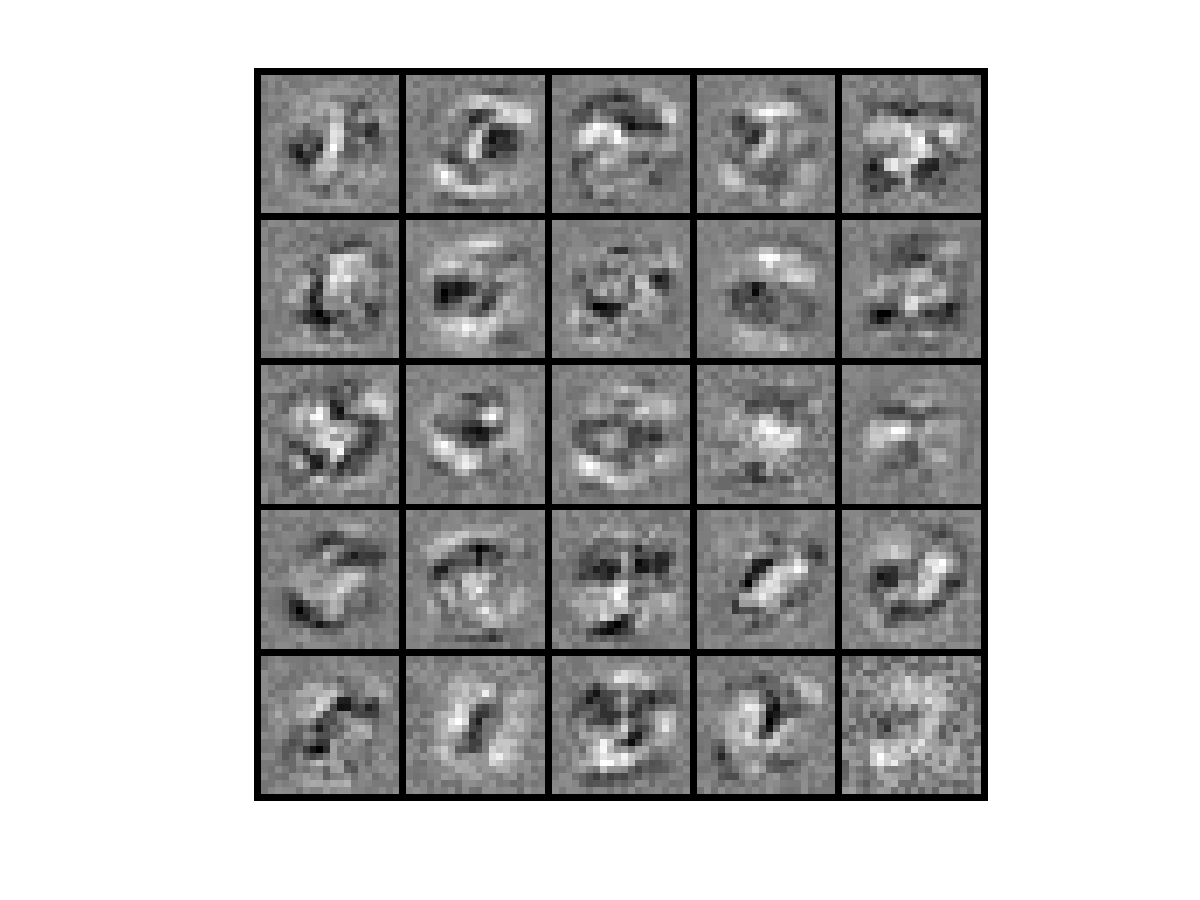

In [17]:
%% ================= Part 9: Visualize Weights =================
%  You can now "visualize" what the neural network is learning by 
%  displaying the hidden units to see what features they are capturing in 
%  the data.

fprintf('\nVisualizing Neural Network... \n')

displayData(Theta1(:, 2:end));

## 3.1 Optional (ungraded) exercise

In this part of the exercise, you will get to try out different learning settings for the neural network to see how the performance of the neural network varies with the regularization parameter $\lambda$ and number of training steps (the `MaxIter` option when using `fmincg`).

Neural networks are very powerful models that can form highly complex decision boundaries. Without regularization, it is possible for a neural network to "overfit" a training set so that it obtains close to 100% accuracy on the training set but does not as well on new examples that it has not seen before. You can set the regularization $\lambda$ to a smaller value and the `MaxIter` parameter to a higher number of iterations to see this for youself.

You will also be able to see for yourself the changes in the visualizations of the hidden units when you change the learning parameters $\lambda$ and `MaxIter`.


Training Neural Network... 
Iteration   400 | Cost: 9.874156e-01

Visualizing Neural Network... 

Training Set Accuracy: 94.320000


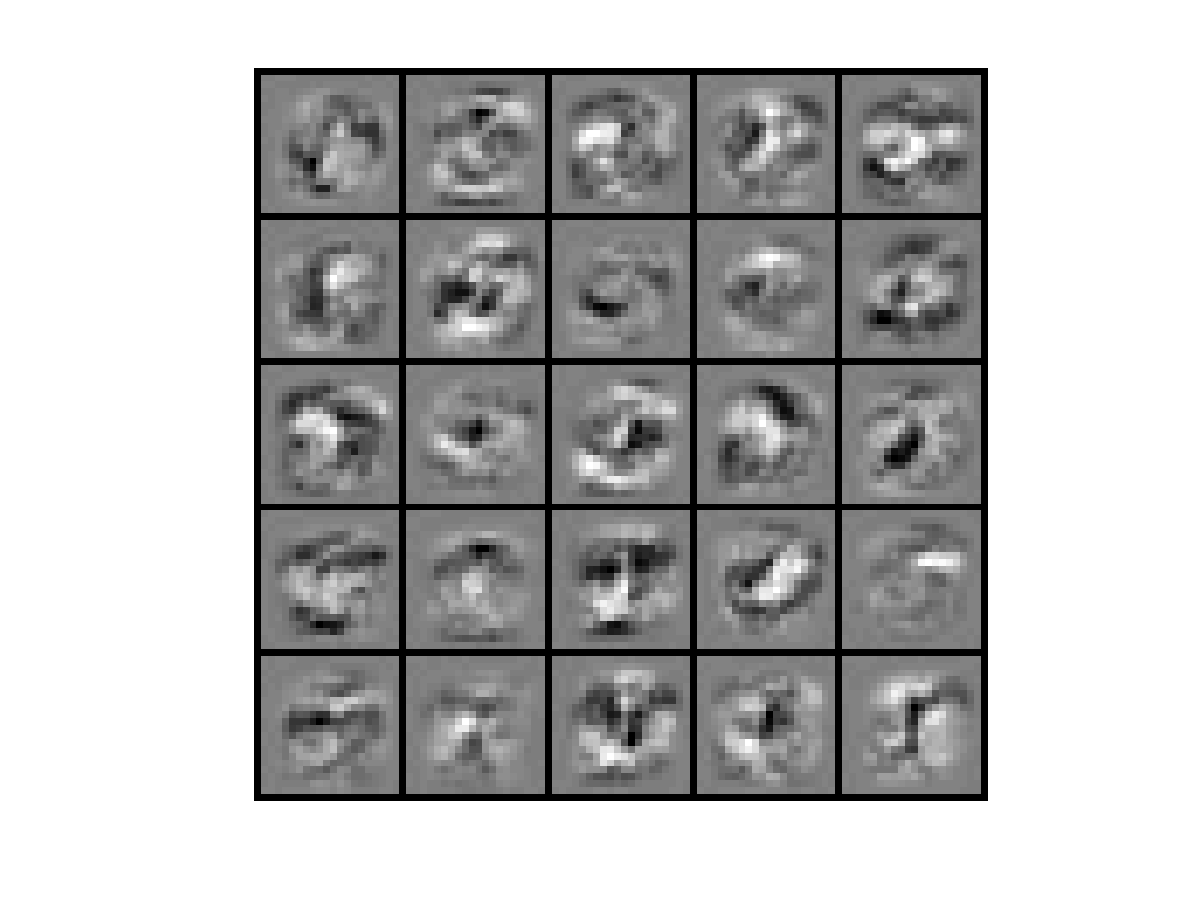

In [20]:
fprintf('\nTraining Neural Network... \n')

%  After you have completed the assignment, change the MaxIter to a larger
%  value to see how more training helps.
options = optimset('MaxIter', 400);

%  You should also try different values of lambda
lambda = 10;

% Create "short hand" for the cost function to be minimized
costFunction = @(p) nnCostFunction(p, ...
                                   input_layer_size, ...
                                   hidden_layer_size, ...
                                   num_labels, X, y, lambda);

% Now, costFunction is a function that takes in only one argument (the
% neural network parameters)
[nn_params, cost] = fmincg(costFunction, initial_nn_params, options);

% Obtain Theta1 and Theta2 back from nn_params
Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                 hidden_layer_size, (input_layer_size + 1));

Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                 num_labels, (hidden_layer_size + 1));
                 
fprintf('\nVisualizing Neural Network... \n')

displayData(Theta1(:, 2:end));

pred = predict(Theta1, Theta2, X);

fprintf('\nTraining Set Accuracy: %f\n', mean(double(pred == y)) * 100);

In [19]:
%% ================= Part 10: Implement Predict =================
%  After training the neural network, we would like to use it to predict
%  the labels. You will now implement the "predict" function to use the
%  neural network to predict the labels of the training set. This lets
%  you compute the training set accuracy.

function p = predict(Theta1, Theta2, X)
    %PREDICT Predict the label of an input given a trained neural network
    %   p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
    %   trained weights of a neural network (Theta1, Theta2)

    % Useful values
    m = size(X, 1);
    num_labels = size(Theta2, 1);

    % You need to return the following variables correctly 
    p = zeros(size(X, 1), 1);

    h1 = sigmoid([ones(m, 1) X] * Theta1');
    h2 = sigmoid([ones(m, 1) h1] * Theta2');
    [dummy, p] = max(h2, [], 2);

    % =========================================================================
end

pred = predict(Theta1, Theta2, X);

fprintf('\nTraining Set Accuracy: %f\n', mean(double(pred == y)) * 100);


Training Set Accuracy: 95.600000
